<a href="https://colab.research.google.com/github/PUPPYMARCHINGON/Amy031013/blob/main/5green_supply_chain_pareto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Install required packages
!pip install pyomo
!apt-get install -y -qq glpk-utils


Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [2]:

from pyomo.environ import *
import pandas as pd


In [3]:

# Define model building function for different (lambda1, lambda2)
def build_model(lambda1, lambda2):
    m = ConcreteModel()

    # Sets
    m.I = Set(initialize=['P1', 'P2'])  # Plants
    m.J = Set(initialize=[f'DC{i}' for i in range(1, 7)])  # DCs
    m.K = Set(initialize=[f'R{i}' for i in range(1, 9)])  # Retailers
    m.R = Set(initialize=['Prod1', 'Prod2'])  # Products
    m.L = Set(initialize=['L1', 'L2', 'L3'])  # Greening levels

    # Parameters
    demand = {
        ('R1', 'Prod1'): 400, ('R1', 'Prod2'): 450,
        ('R2', 'Prod1'): 200, ('R2', 'Prod2'): 300,
        ('R3', 'Prod1'): 250, ('R3', 'Prod2'): 200,
        ('R4', 'Prod1'): 180, ('R4', 'Prod2'): 250,
        ('R5', 'Prod1'): 300, ('R5', 'Prod2'): 220,
        ('R6', 'Prod1'): 280, ('R6', 'Prod2'): 260,
        ('R7', 'Prod1'): 270, ('R7', 'Prod2'): 320,
        ('R8', 'Prod1'): 220, ('R8', 'Prod2'): 280,
    }
    m.d = Param(m.K, m.R, initialize=demand)

    supply_mean = {
        ('P1', 'Prod1'): 1800, ('P1', 'Prod2'): 1700,
        ('P2', 'Prod1'): 1600, ('P2', 'Prod2'): 1500,
    }
    m.s = Param(m.I, m.R, initialize=supply_mean)

    fixed_cost = {'L1': 120, 'L2': 100, 'L3': 80}
    m.f = Param(m.L, initialize=fixed_cost)

    emission = {'L1': 0.8, 'L2': 1.0, 'L3': 1.2}
    m.e = Param(m.L, initialize=emission)

    # Decision Variables
    m.x = Var(m.I, m.J, m.R, domain=NonNegativeReals)
    m.y = Var(m.J, m.K, m.R, domain=NonNegativeReals)
    m.omega = Var(m.J, m.L, domain=Binary)
    m.z = Var(m.J, m.K, m.R, m.L, domain=NonNegativeReals)

    # Constraints
    def supply_rule(m, i, r):
        return sum(m.x[i, j, r] for j in m.J) <= m.s[i, r]
    m.Supply = Constraint(m.I, m.R, rule=supply_rule)

    def demand_rule(m, k, r):
        return sum(m.y[j, k, r] for j in m.J) >= m.d[k, r]
    m.Demand = Constraint(m.K, m.R, rule=demand_rule)

    def flow_rule(m, j, r):
        return sum(m.x[i, j, r] for i in m.I) >= sum(m.y[j, k, r] for k in m.K)
    m.Flow = Constraint(m.J, m.R, rule=flow_rule)

    def onehot_rule(m, j):
        return sum(m.omega[j, l] for l in m.L) == 1
    m.OneHot = Constraint(m.J, rule=onehot_rule)

    # Linearization of z = y * omega
    M = 1e5
    def bigM1(m, j, k, r, l): return m.z[j, k, r, l] <= m.y[j, k, r]
    def bigM2(m, j, k, r, l): return m.z[j, k, r, l] <= M * m.omega[j, l]
    def bigM3(m, j, k, r): return sum(m.z[j, k, r, l] for l in m.L) == m.y[j, k, r]
    m.BigM1 = Constraint(m.J, m.K, m.R, m.L, rule=bigM1)
    m.BigM2 = Constraint(m.J, m.K, m.R, m.L, rule=bigM2)
    m.BigM3 = Constraint(m.J, m.K, m.R, rule=bigM3)

    # Expressions
    def cost_expr(m):
        transport_cost = sum(m.x[i, j, r]*1 + m.y[j, k, r]*1 for i in m.I for j in m.J for k in m.K for r in m.R)
        fixed = sum(m.omega[j, l] * m.f[l]*10000 for j in m.J for l in m.L)
        return transport_cost + fixed

    def emission_expr(m):
        return sum(m.z[j, k, r, l]*m.e[l] for j in m.J for k in m.K for r in m.R for l in m.L)

    # Objective
    m.obj = Objective(expr=lambda1 * cost_expr(m) + lambda2 * emission_expr(m), sense=minimize)

    return m


In [4]:

lambda_pairs = [(round(l1, 2), round(1 - l1, 2)) for l1 in [i * 0.1 for i in range(11)]]
results = []

for l1, l2 in lambda_pairs:
    model = build_model(l1, l2)
    solver = SolverFactory('glpk')
    solver.solve(model)

    results.append({
        'lambda1': l1,
        'lambda2': l2,
        'objective': value(model.obj),
    })

df = pd.DataFrame(results)
df


,lambda1,lambda2,objective
0,0.0,1.0,3504.0
1,0.1,0.9,489110.4
2,0.2,0.8,972964.8
3,0.3,0.7,1456819.2
4,0.4,0.6,1940673.6
5,0.5,0.5,2424528.0
6,0.6,0.4,2908382.4
7,0.7,0.3,3392236.8
8,0.8,0.2,3876091.2
9,0.9,0.1,4359945.6


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['lambda1'].plot(kind='hist', bins=20, title='lambda1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['lambda2'].plot(kind='hist', bins=20, title='lambda2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['objective'].plot(kind='hist', bins=20, title='objective')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='lambda1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='lambda1', y='lambda2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='lambda2', y='objective', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

AttributeError: '_PyDrive2ImportHook' object has no attribute 'find_spec'

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['lambda2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('lambda2')

AttributeError: '_PyDrive2ImportHook' object has no attribute 'find_spec'

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

AttributeError: '_PyDrive2ImportHook' object has no attribute 'find_spec'

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['lambda1']
  ys = series['lambda2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('lambda1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lambda1')
_ = plt.ylabel('lambda2')

AttributeError: '_PyDrive2ImportHook' object has no attribute 'find_spec'

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['lambda1']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'lambda1'}, axis=1)
              .sort_values('lambda1', ascending=True))
  xs = counted['lambda1']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('lambda1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('lambda1')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['lambda1'].plot(kind='line', figsize=(8, 4), title='lambda1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['lambda2'].plot(kind='line', figsize=(8, 4), title='lambda2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['objective'].plot(kind='line', figsize=(8, 4), title='objective')
plt.gca().spines[['top', 'right']].set_visible(False)

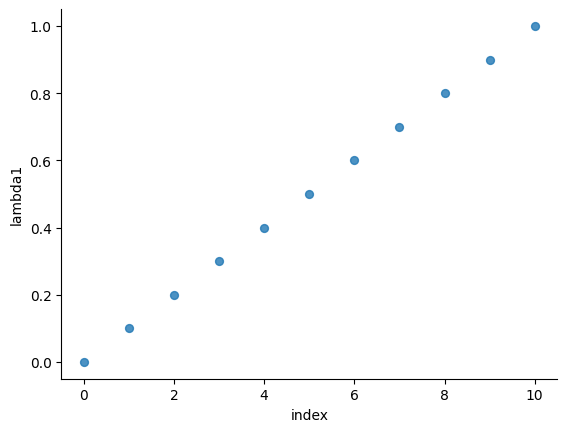

In [5]:
from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='lambda1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)